# Stakeholder

Apple as stakeholder and compare sentiment of its release vs. Google's at SXSW

# Preprocessing

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import re

df = pd.read_csv('../data/tweets.csv', encoding = 'iso-8859-1')
sw = stopwords.words('english')

In [101]:
#Gets rid of company column
tweets = df.drop('emotion_in_tweet_is_directed_at', axis = 1)

In [102]:
tweets['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [103]:
#Drops rows with unknown sentiment
tweets = tweets[tweets['is_there_an_emotion_directed_at_a_brand_or_product'] != 'I can\'t tell']

In [104]:
#Renames column with sentiments as label and drops single nan row
tweets['label'] = tweets['is_there_an_emotion_directed_at_a_brand_or_product']
tweets = tweets.drop('is_there_an_emotion_directed_at_a_brand_or_product', axis = 1)
tweets = tweets.dropna()

In [105]:
tweets.label.value_counts(normalize = True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333259
Negative emotion                      0.063787
Name: label, dtype: float64

In [106]:
#Reassigns label
tweets.label = tweets.label.map({'Negative emotion' : 0, 'Positive emotion': 1, 
                                 'No emotion toward brand or product': 2})

tweets.label.value_counts(normalize = True)

2    0.602954
1    0.333259
0    0.063787
Name: label, dtype: float64

In [216]:
#Functions to tokenize text
import string

#Replaces pos tags with lemmatize compatable tags
def pos_replace(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
#Makes list of punctuation to exclude, keeps certain symbols
punct = list(string.punctuation)
keep_punct = ['#', '?', '!', '@']
punct = [p for p in punct if p not in keep_punct]

#Used to filter out words leftover by twitter scrape
common_tweet_words = ['#sxsw', 'rt']

#Removes non-ASCII characters (aka emojis that cant be converted to original symbol)
def remove_junk(tweet):
    return ''.join([i if ord(i) < 128 else ' ' for i in tweet])
    
#TRY LOWERING/NOT LEMMATIZING AND SEE WHAT CHANGES
def tweet_tokenizer(doc, stop_words = sw):
    #Gets rid of links
    doc = re.sub(r'http\S+', '', doc)
    doc = re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', '', doc)
    #Gets rid of conversions made during scrapping
    doc = re.sub(r'{link}', '', doc)
    doc = re.sub(r'\[video\]', '', doc)
    #Gets rid of weird characters
    doc = remove_junk(doc)
    #Tokenizes using NLTK Twitter Tokenizer
    tweet_token = TweetTokenizer(strip_handles = True)
    doc = tweet_token.tokenize(doc)
    #Gets rid of leftover stopwords/punctuation/twitter meta-info
    #doc = [w for w in doc if w.lower() not in sw]
    doc = [w for w in doc if w.lower() not in common_tweet_words]
    doc = [w for w in doc if w not in punct]
    #Lemmatizes tokens
    doc = pos_tag(doc)
    doc = [(w[0], pos_replace(w[1])) for w in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return doc

In [215]:
t = tweets.loc[38, 'tweet_text']
test = tweet_tokenizer(t)
print(t)
print('\n')
print(test)

@mention  - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW


['False', 'Alarm', 'Google', 'Circles', 'Coming', 'Probably', 'Ever', '?', '#Google', '#Circles', '#Social']


# Visualizing Features with Graphs

In [87]:
from matplotlib.ticker import MaxNLocator

def setup_three_subplots():
    """
    It's hard to make an odd number of graphs pretty with just nrows
    and ncols, so we make a custom grid. See example for more details:
    https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html

    We want the graphs to look like this:
     [ ] [ ] [ ]
       [ ] [ ]

    So we make a 2x6 grid with 5 graphs arranged on it. 3 in the
    top row, 2 in the second row

      0 1 2 3 4 5
    0|[|]|[|]|[|]|
    1| |[|]|[|]| |
    """
    fig = plt.figure(figsize=(15,9))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :2]) # row 0, cols 0-1
    ax2 = fig.add_subplot(gs[0, 2:4])# row 0, cols 2-3
    #ax3 = fig.add_subplot(gs[0, 4:]) # row 0, cols 4-5
    ax4 = fig.add_subplot(gs[1, 1:3])# row 1, cols 1-2
    #ax5 = fig.add_subplot(gs[1, 3:5])# row 1, cols 3-4
    return fig, [ax1, ax2, ax4]

def plot_distribution_of_column_by_category(column, axes, title="Word Frequency for"):
    for index, category in enumerate([0, 1, 2]):
        # Calculate frequency distribution for this subset
        all_words = tweets[tweets["label"] == index][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]

        # Set up plot
        ax = axes[index]
        ax.hist(tokens, counts)

        # Customize plot appearance
        ax.set_title(f"{title} {category}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=90)

# Data Exploration

In [150]:
from nltk.probability import FreqDist

all_words = []
for tweet in tweets['tweet_text']:
    all_words.extend(tweet_tokenizer(tweet))


In [151]:
words = set(all_words)
len(words)
#print(words)

11507

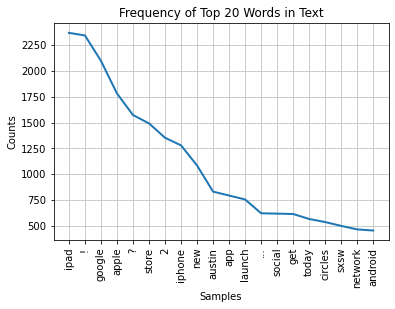

<AxesSubplot:title={'center':'Frequency of Top 20 Words in Text'}, xlabel='Samples', ylabel='Counts'>

In [152]:
fdist = FreqDist()
for word in all_words:
    fdist[word.lower()] += 1
    
fdist.plot(20, title = 'Frequency of Top 20 Words in Text')

# Feature Creation

In [79]:
#Look for excessive puntuation - no go
def punc_count(tweet):
    punctuations = '!$%&()*+,-./:;<=>?[\]^_`{|}~'
    count = 0
    for p in punctuations:
        count += tweet.count(p)
    return count

#Look for excessive !/?'s' - no go
def exc_que_count(tweet):
    punctuation = '!?'
    count = 0
    for p in punctuation:
        count += tweet.count(p)
    return count

#only periods
def period_count(tweet):
    punctuation = '.'
    count = 0
    for p in punctuation:
        count += tweet.count(p)
    return count

#Ratio capital to length tweet
def capital_letter_ratio(tweet):
    capital_count = 0
    for c in tweet:
        if c.isupper():
            capital_count += 1
    return capital_count / len(tweet)

#Repeating words - fix to be adjacent
def any_repeats(tweet):
    if len(set(tweet.split())) < len(tweet.split()):
        return 1
    else:
        return 0 
    
#Hashtag count
def count_hash(tweet):
    hashtag = re.findall(r'(#w[A-Za-z0-9]*)', tweet)
    return len(hashtag)

#Average word length
def avg_length(tweet):
    char = len(tweet)
    word = len(tweet.split())
    return char / word

#Number of words
def word_count(tweet):
    return len(tweet.split())

#Add in if tweet about Apple or Google?

#Add in what service/product talk about?

# Get rid of bad data

In [107]:
tweets['word_count'] = tweets['tweet_text'].apply(word_count)
tweets['word_count'].describe()

count    8936.000000
mean       17.767793
std         4.961420
min         2.000000
25%        14.000000
50%        18.000000
75%        21.000000
max        33.000000
Name: word_count, dtype: float64

In [108]:
tweets[tweets['word_count'] == 2]

,tweet_text,label,word_count
5025,RT @mention,2,2


In [109]:
tweets = tweets[tweets['word_count'] != 2]

In [83]:
# negative = tweets[tweets.label == 0]
# tweet_tokenizer(negative['tweet_text'][291])

['Apple',
 'store',
 'mall',
 'Sunday',
 '10x',
 'crowd',
 'line',
 'fake',
 'need',
 'fuck',
 'dongle',
 'Genius',
 'let']

# Visualize Different Features

In [92]:
tweets['punc_count'] = tweets['tweet_text'].apply(punc_count)

In [86]:
#tweets.groupby('label')['exc_que_count'].value_counts()

In [94]:
# fig, axes = setup_three_subplots()
# plot_distribution_of_column_by_category("punc_count", axes, "Freqency of Posts Containing Prices for")

# Test Each Feature With Logreg Cause Visuals Are Hard

In [95]:
tweets_test = tweets.drop('tweet_text', axis = 1)

In [96]:
#Train test split
y = tweets_test['label']
X = tweets_test.drop('label', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

X_train

,word_count,exc_que_count,punc_count
7225,7,0,1
5863,13,0,4
3045,11,0,4
2367,20,3,6
7846,19,0,1
...,...,...,...
7766,15,1,5
3886,22,0,2
1039,19,0,6
8170,18,1,6


In [89]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

features = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(max_depth = 5, random_state = 213))
])

features.fit(X_train, y_train)
for name, importance in zip(X_train.columns, features['dtc'].feature_importances_):
    print(name, importance)

word_count 0.06002538528680205
punc_count 0.17909048047757065
exc_que_count 0.19944959489690914
capital_letter_ratio 0.2319134369654643
any_repeats 0.08832240109620128
count_hash 0.0
avg_length 0.1428706650931737
period_count 0.09832803618387893


# Different Vectorizers

In [59]:
#Train test split
y = tweets['label']
X = tweets.drop('label', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

col_labels = list(X_train.columns)
col_labels.remove('tweet_text')

### CountVectorizer

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

#Vectorize the words
cv = CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)
X_train_cv = cv.fit_transform(X_train['tweet_text'])

#Scales the non-word columns
X_train_nowords = X_train[col_labels]
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_nowords),columns = X_train_nowords.columns, index = X_train.index)

#Combines the scaled and vectorized data together
X_train_cv_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names(), index = X_train.index)
X_train_final = pd.concat([X_train_cv_df, X_train_scaled], axis=1)

#SMOTE HERE

### TF_IDF Vec

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)
X_train_tfidf = tfidf.fit_transform(X_train['tweet_text'])

#Scales the non-word columns
X_train_nowords = X_train[col_labels]
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_nowords),columns = X_train_nowords.columns, index = X_train.index)

#Combines vectorized and scaled data together
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns = tfidf.get_feature_names(), index = X_train.index)
X_train_final = pd.concat([X_train_tfidf_df, X_train_scaled], axis=1)

#SMOTE HERE

# Models

### Multinomial Bayes - ONLY TEXT

In [217]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

#Train test split
y = tweets['label']
X = tweets['tweet_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

#Vectorize the words
cv = CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)
X_train_cv = cv.fit_transform(X_train)

#Fit and print model scores
first_pass = MultinomialNB()
first_pass.fit(X_train_cv, y_train)
print("Training Score:", first_pass.score(X_train_cv, y_train))
scores = np.mean(cross_val_score(first_pass, X_train_cv, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.8327115355917027
Validation Score:0.6515432902601088


### Other models - can add other features

# IGNORE/TESTING AREA

## IF WANT TRY PIPELINE/ADD FEATURE THINGY

In [ ]:
"""
from sklearn.pipeline import FeatureUnion, Pipeline
count_vec = FeatureUnion([
        ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer))
        #, add any feature creation things here
    ])

tfidf_vec = FeatureUnion([
        ('tfidf', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer))
        #, add any feature creation things here
    ])

first_pass = Pipeline(steps=[
    ('vec', count_vec),
    ('mnb', MultinomialNB())
])
"""

In [80]:
def punc_count(tweet):
    punctuations = '!$%&()*+,-./:;<=>?[\]^_`{|}~'
    count = 0
    for p in punctuations:
        count += tweet.count(p)
    return count

In [102]:
from sklearn.base import BaseEstimator, TransformerMixin

class PuncCount(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return pd.Series(X).apply(punc_count)

In [96]:
y = tweets['label']
X = tweets['tweet_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

In [98]:
from sklearn.pipeline import FeatureUnion, Pipeline

count_vec = FeatureUnion([
        ('punc', PuncCount()),
        ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer))
    ])

first_pass = Pipeline(steps=[
    ('preproc', count_vec),
    #('ss', StandardSclaer()) - only if added features on diff scale
    ('mnb', MultinomialNB())
])

first_pass.fit(X_train, y_train)
print("Training Score:", first_pass.score(X_train, y_train))
scores = np.mean(cross_val_score(first_pass, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 6701, expected 1.

In [94]:
pc = PuncCount()
pc.fit(X_train)
test = pc.transform(X_train)
test

<1x6701 sparse matrix of type '<class 'numpy.int64'>'
	with 6479 stored elements in Compressed Sparse Row format>

# Baseline Model

In [218]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

y = tweets['label']
X = tweets['tweet_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

baseline = imbpipeline(steps=[
    ('preproc', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213, max_depth = 5))
])

baseline.fit(X_train, y_train)
print("Training Score:", baseline.score(X_train, y_train))
scores = np.mean(cross_val_score(baseline, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.47157140725264884
Validation Score:0.4588858837802041


# Iterating Models

In [220]:
#Making final dataset
tweets['capital_letter_ratio'] = tweets['tweet_text'].apply(capital_letter_ratio)
tweets['exc_que_count'] = tweets['tweet_text'].apply(exc_que_count)
tweets = tweets.drop('word_count', axis = 1)
tweets.head()

,tweet_text,label,capital_letter_ratio,exc_que_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0,0.118110,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1,0.071942,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1,0.088608,0
3,@sxsw I hope this year's festival isn't as cra...,0,0.024390,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1,0.106870,0


In [221]:
#Train test split
y = tweets['label']
X = tweets.drop('label', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

col_labels = list(X_train.columns)
col_labels.remove('tweet_text')

### MNB - No Tuning

In [223]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

first = imbpipeline(steps=[
    ('preproc', count_vec),
    ('mnb', MultinomialNB())
])

first.fit(X_train, y_train)
print("Training Score:", first.score(X_train, y_train))
scores = np.mean(cross_val_score(first, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))


Training Score: 0.8131622145948366
Validation Score:0.6610949725644707


### Logistic Regression - No Tuning

In [214]:
from sklearn.linear_model import LogisticRegression

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

second = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('logreg', LogisticRegression(random_state = 213, max_iter = 1000))
])

second.fit(X_train, y_train)
print("Training Score:", second.score(X_train, y_train))
scores = np.mean(cross_val_score(second, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.9292642889121027
Validation Score:0.66288668514252


### Logreg - gridsearch

In [37]:
from sklearn.model_selection import GridSearchCV

#Creates parameters to test
params = {
    'logreg__C': [1.0, 1e3, 1e6],
    'logreg__solver': ['lbfgs', 'saga']
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(second, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

{'logreg__C': 1.0, 'logreg__solver': 'lbfgs'}

### This would be where our tuned logreg went - if we had one

In [ ]:
# Unknown tuned (?) model

### MNB - Gridsearch (lowercase/min max)

In [38]:
#Creates parameters to test
params = {
    'preproc__cv__lowercase': [True, False],
    'preproc__cv__min_df': [0, .05, .1],
    'preproc__cv__max_df': [1, .95, .9]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(first, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 229, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipelin

{'preproc__cv__lowercase': False,
 'preproc__cv__max_df': 0.95,
 'preproc__cv__min_df': 0}

In [126]:
#Tuned MNB
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          max_df = .95), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

tuned_mnb = imbpipeline(steps=[
    ('preproc', count_vec),
    ('mnb', MultinomialNB())
])

tuned_mnb.fit(X_train, y_train)
print("Training Score:", tuned_mnb.score(X_train, y_train))
scores = np.mean(cross_val_score(tuned_mnb, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.835397701835547
Validation Score:0.6596012109474997


### MNB - gridsearch (ngram)

In [127]:
from sklearn.model_selection import GridSearchCV

#Creates parameters to test
params = {
    'preproc__cv__ngram_range': [(1,1), (1,2), (2,2)]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(tuned_mnb, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

{'preproc__cv__ngram_range': (1, 2)}

In [167]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          max_df = .95, ngram_range = (1,2)), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

ngram = imbpipeline(steps=[
    ('preproc', count_vec),
    ('mnb', MultinomialNB())
])

ngram.fit(X_train, y_train)
print("Training Score:", ngram.score(X_train, y_train))
scores = np.mean(cross_val_score(ngram, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.9186688553947172
Validation Score:0.6800486382405645


### MNB - gridsearch ngram max features

In [175]:
from sklearn.model_selection import GridSearchCV

#Creates parameters to test
params = {
    'preproc__cv__max_features': [None, 8000, 4000],
    'preproc__cv__max_df': [.3, .5, .8],
    'preproc__cv__ngram_range': [(1,1), (1,2), (2,2)]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(ngram, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

{'preproc__cv__max_df': 0.5,
 'preproc__cv__max_features': 8000,
 'preproc__cv__ngram_range': (1, 1)}

In [176]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          ngram_range = (1,1), max_df = .7, max_features = 8000), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

test = imbpipeline(steps=[
    ('preproc', count_vec),
    ('mnb', MultinomialNB())
])

test.fit(X_train, y_train)
print("Training Score:", test.score(X_train, y_train))
scores = np.mean(cross_val_score(test, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.8288315176839278
Validation Score:0.6718400169176488


### Decision Tree - Tuning

In [56]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

tree = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213))
])

tree.fit(X_train, y_train)
print("Training Score:", tree.score(X_train, y_train))
scores = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.9989553797940606
Validation Score:0.6212522399189734


In [54]:
#Creates parameters to test
params = {
    'dtc__max_depth': [10, 20, 30],
    'dtc__min_samples_split': [2, 5, 10]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(tree, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

{'dtc__max_depth': 30, 'dtc__min_samples_split': 2}

In [57]:
#min sample split = 5/max_depth = 20 has less overfitting
tree = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213, min_samples_split = 2, max_depth = 30))
])

tree.fit(X_train, y_train)
print("Training Score:", tree.score(X_train, y_train))
scores = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.7780928219668706
Validation Score:0.6375170011241332


## DTC w/ bigrams

In [72]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          ngram_range = (1,2)), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

dtc_test = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213))
])

dtc_test.fit(X_train, y_train)
print("Training Score:", dtc_test.score(X_train, y_train))
scores = np.mean(cross_val_score(dtc_test, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.9992538427100432
Validation Score:0.6325916279898048


In [76]:
#Creates parameters to test
params = {
    'dtc__max_depth': [20, 30, 40],
    'dtc__criterion': ['entropy', 'gini']
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(dtc_test, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

{'dtc__criterion': 'gini', 'dtc__max_depth': 30}

In [74]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          ngram_range = (1,2)), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

dtc_test = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213, max_depth = 30, max_features = 3000))
])

dtc_test.fit(X_train, y_train)
print("Training Score:", dtc_test.score(X_train, y_train))
scores = np.mean(cross_val_score(dtc_test, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.7130279062826443
Validation Score:0.6245295891905128


## Logreg with bigram

In [85]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          ngram_range = (1,2), max_features = 1500), 'tweet_text'),
    ('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

logreg_worse = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state = 213)),
    ('logreg', LogisticRegression(random_state = 213, max_iter = 1000))
])

logreg_worse.fit(X_train, y_train)
print("Training Score:", logreg_worse.score(X_train, y_train))
scores = np.mean(cross_val_score(logreg_worse, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.7667512311595285
Validation Score:0.5964791256246731


In [86]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          ngram_range = (1,2)), 'tweet_text'),
    ('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

logreg_bi = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state = 213)),
    ('logreg', LogisticRegression(random_state = 213, max_iter = 1000))
])

logreg_bi.fit(X_train, y_train)
print("Training Score:", logreg_bi.score(X_train, y_train))
scores = np.mean(cross_val_score(logreg_bi, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.9737352633935233
Validation Score:0.6773597337696307


In [83]:
#Creates parameters to test
params = {
    'preproc__cv__ngram_range': [(1,1), (1,2), (2,2)],
    'preproc__cv__max_features': [None, 1000, 2000]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(logreg_bi, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

{'preproc__cv__max_features': None, 'preproc__cv__ngram_range': (1, 2)}

# Word2Vec

In [187]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
            
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
from gensim.models import word2vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

all_words = []
for tweet in tweets['tweet_text']:
    all_words.extend(tweet_tokenizer(tweet))
    

vocab_mix = set(all_words)
test = []
for word in vocab_mix:
    test.append(word.lower())
vocab = set(test)

glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [198]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

y = tweets['label']
X = tweets['tweet_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#Pick a Pipeline to try
w2v_rfc = Pipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('rf', RandomForestClassifier(random_state = 42))
])

w2v_svc = Pipeline([
    ('Word2Vec Vectorizer', W2vVectorizer(glove)),
    ('Support Vector Machine', SVC())
])

w2v_logreg = Pipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('lr', LogisticRegression(max_iter = 1000, random_state = 42))
])

models = [('Random Forest', w2v_rfc),
          ('Support Vector Machine', w2v_svc),
          ('Logistic Regression', w2v_logreg)]

scores = [(name, cross_val_score(model, X_train, y_train, cv = 3).mean()) for name, model, in models]
scores

[('Random Forest', 0.6203548866778577),
 ('Support Vector Machine', 0.6028950725953165),
 ('Logistic Regression', 0.6178179295056399)]

In [196]:
#Creates parameters to test
params = {
    'rf__n_estimators': [100, 300, 500],
    'rf__min_samples_split': [2, 5, 10]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(w2v_rfc, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

{'rf__criterion': 'gini', 'rf__min_samples_split': 2, 'rf__n_estimators': 300}

In [197]:
w2v_tuned = Pipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('rf', RandomForestClassifier(n_estimators = 300, random_state = 42))
])

w2v_tuned.fit(X_train, y_train)
print("Training Score:", w2v_tuned.score(X_train, y_train))
scores = np.mean(cross_val_score(w2v_tuned, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.995672287718251
Validation Score:0.6236379623137112


# Word2Vec with SMOTE

In [201]:
w2v_rfc = imbpipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('rf', RandomForestClassifier(random_state = 42))
])

w2v_svc = imbpipeline([
    ('Word2Vec Vectorizer', W2vVectorizer(glove)),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('Support Vector Machine', SVC())
])

w2v_logreg = imbpipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('lr', LogisticRegression(max_iter = 1000, random_state = 42))
])

models = [('Random Forest', w2v_rfc),
          ('Support Vector Machine', w2v_svc),
          ('Logistic Regression', w2v_logreg)]

scores = [(name, cross_val_score(model, X_train, y_train, cv = 3).mean()) for name, model, in models]
scores

[('Random Forest', 0.5834954722059961),
 ('Support Vector Machine', 0.39083807455060504),
 ('Logistic Regression', 0.4484387693723044)]

In [204]:
#Creates parameters to test
params = {
    'rf__n_estimators': [500, 800, 1000],
    'rf__min_samples_split': [2, 5, 10]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(w2v_rfc, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

{'rf__min_samples_split': 2, 'rf__n_estimators': 800}

In [205]:
w2v_tuned = Pipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('rf', RandomForestClassifier(n_estimators = 800, min_samples_split = 2, random_state = 42))
])

w2v_tuned.fit(X_train, y_train)
print("Training Score:", w2v_tuned.score(X_train, y_train))
scores = np.mean(cross_val_score(w2v_tuned, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.995672287718251
Validation Score:0.6279663205226663


# Getting only Apple Tweets

In [35]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [50]:
no_labels = df[df['emotion_in_tweet_is_directed_at'].isna()]
no_labels = no_labels.dropna(subset = ['tweet_text'])

In [71]:
tweet_list = []
for tweet in no_labels['tweet_text']:
    tweet_check = tweet.lower()
    if ('iphone' in tweet_check) or ('ipad' in tweet_check) or ('apple' in tweet_check):
        tweet_list.append(tweet)

In [59]:
ipad = df[df['emotion_in_tweet_is_directed_at'] == 'iPad']
apple = df[df['emotion_in_tweet_is_directed_at'] == 'Apple']
mix = df[df['emotion_in_tweet_is_directed_at'] == 'iPad or iPhone App']
iphone = df[df['emotion_in_tweet_is_directed_at'] == 'iPhone']
apps = df[df['emotion_in_tweet_is_directed_at'] == 'Other Apple product or service']

unlabeled_apple = df[df['tweet_text'].isin(tweet_list)]
unlabeled_apple = unlabeled_apple.drop_duplicates(subset = 'tweet_text')

final_df = pd.concat([ipad, apple, mix, iphone, apps, unlabeled_apple], axis = 0)

final_df.head()

35

In [84]:
final_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize = True)

No emotion toward brand or product    0.519993
Positive emotion                      0.386466
Negative emotion                      0.075629
I can't tell                          0.017912
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [89]:
len(final_df)

5527

In [91]:
len(tweets) - len(final_df)

3408